In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import matlib
import seaborn as sns
from PyalData.pyaldata.interval import restrict_to_interval 
from numpy.linalg import eig
from mpl_toolkits import mplot3d
import matplotlib.cm as cm



In [2]:
#orig_df = pd.read_hdf('Test_Output2.h5')
orig_df = pd.read_pickle('Test_Output.pkl')

In [3]:
# Generates speed row vector for each trial array
def generate_speed(position):
    # Function for each trial
    # print(len(position))
    speedposition = np.zeros(len(position-1))
    for i in range(len(position)-1):
        x_speed = (position[i+1][0] - position[i][0])/5
        y_speed = (position[i+1][1] - position[i][1])/5
        speedposition[i] = np.sqrt(x_speed*x_speed + y_speed*y_speed)
       
    return speedposition


(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)
(81, 2)


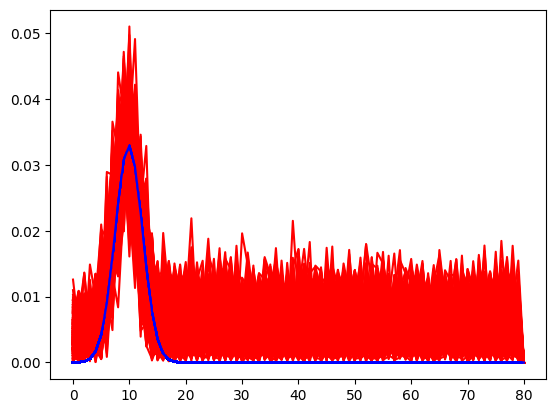

In [4]:
hand_model_output = restrict_to_interval(orig_df,"idx_go_cue","idx_trial_end",0,0,None,None,None,False, True, 'hand_model_output')
hand_target_output = restrict_to_interval(orig_df,"idx_go_cue","idx_trial_end",0,0,None,None,None,False, True, 'hand_target_output')
position_info = hand_model_output.loc[:,"hand_model_output"]
theo_position_info = hand_model_output.loc[:,'hand_target_output']

# Extract 640 trial array of trial
for i in range(len(position_info)):
    speed_trial= generate_speed(position_info[i])
    print(position_info[i].shape)
    theo_speed = generate_speed(theo_position_info[i])
    plt.plot(speed_trial, 'r')
    plt.plot(theo_speed, 'b')
    
plt.show()

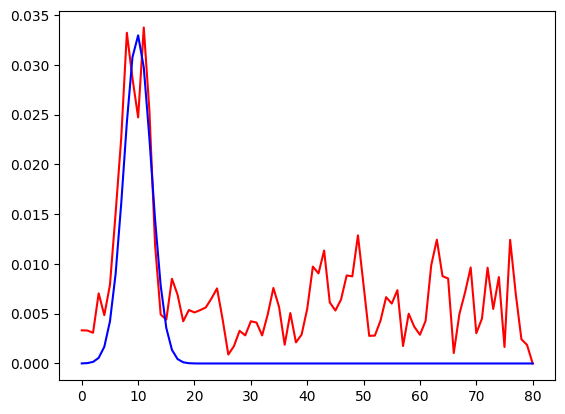

In [5]:
speed_trial= generate_speed(position_info[4])
theo_speed = generate_speed(theo_position_info[4])
plt.plot(speed_trial, 'r')
plt.plot(theo_speed, 'b')

plt.show()

In [6]:
#orig_df = pd.read_pickle('Test_OutputUnrestricted.pkl')
preparatory_rates = restrict_to_interval(orig_df,"idx_target_on","idx_go_cue",0,0,None,None,None,False, True, 'motor_cortex_rates')
movement_rates = restrict_to_interval(orig_df,"idx_go_cue","idx_trial_end",0,0,None,None,None,False, True, 'motor_cortex_rates')
all_rates = orig_df
# all_rates = restrict_to_interval(orig_df, "idx_go_cue","idx_trial_end",0,0,None,None,None,False, True, 'motor_cortex_rates')
# Delay in movement
# take whole trial, calculate first 3 principal components projecgt entire data set

In [7]:
# Access the series of preparatory rates to find smallest array
# preparatory_rates = preparatory_rates.loc['motor_cortex_rates']

# Finds the minimum number of time points in a given epoch
def minSeries(series):
    size = len(series.iloc[0])
    for i in range(len(series)):
        size1 = len(series.iloc[i])
        print(size1)
        if size1 < size:
            size = size1
    return size 


In [8]:
# Finds the max number of time points in a given epoch
def maxSeries(series):
    size = len(series.iloc[0])
    for i in range(len(series)):
        size1 = len(series.iloc[i])
        # print(size1)
        if size1 > size:
            size = size1
    return size 

In [9]:
# Shortens all trial rates to the same number of time points
def standardise(series, smallest):
    seriesShort = series
    for i in range(len(series)):
        seriesShort.iloc[i] = seriesShort.iloc[i][:smallest]
        #print(seriesShort.iloc[i].shape)
    return seriesShort

In [10]:
def lengthen(series, largest):
    seriesLong = series
    for i in range(len(series)):
        length = len(seriesLong.iloc[i])
        print("length = ",length)
        print("largest = ", largest)
        if length < largest:
            difference = largest - length
            padding = np.zeros(400)
            for j in range(difference-1):
                unit = np.zeros(400)
                padding = np.vstack([padding,unit])
            seriesLong.iloc[i] = np.vstack([seriesLong.iloc[i], padding])
        print(seriesLong.iloc[i].shape)   
    return seriesLong 

In [11]:
# To create separation between preparation and movement
def cut(dataframe, cutoff, epoch):
    # if preparatory, remove cutoff values from back, if movement remove cutoff calues from the front
    series = dataframe['motor_cortex_rates']
    
    length = series.shape[0]
    timePoints = series.iloc[0].shape[0]
    
    if epoch == "preparatory":
        for i in range(length):
        
            series.iloc[i] = series.iloc[i][0:(timePoints-cutoff)]
            print(series.iloc[i].shape)


    elif epoch == "movement":
        for i in range(length):
            series.iloc[i] = series.iloc[i][cutoff:timePoints]

    return dataframe

In [12]:
preparatory_rates = cut(preparatory_rates,10,"preparatory")

movement_rates = cut(movement_rates,10,"movement")

# minprep = minSeries(preparatory_rates['motor_cortex_rates'])

# minmove = minSeries(movement_rates['motor_cortex_rates'])

# idx_trial start to trial end
#maxall = maxSeries(all_rates['motor_cortex_rates'])
#adjusted = lengthen(all_rates['motor_cortex_rates'], maxall)


(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)


/tmp/ipykernel_2740930/3785430865.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[i] = series.iloc[i][0:(timePoints-cutoff)]
/tmp/ipykernel_2740930/3785430865.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[i] = series.iloc[i][cutoff:timePoints]


In [13]:
print(preparatory_rates['motor_cortex_rates'].iloc[0].shape)
print(preparatory_rates['motor_cortex_rates'].iloc[1].shape)
print(preparatory_rates['motor_cortex_rates'].iloc[2].shape)
print(preparatory_rates['motor_cortex_rates'].iloc[3].shape)
print(preparatory_rates['motor_cortex_rates'].iloc[4].shape)
print(preparatory_rates['motor_cortex_rates'].iloc[5].shape)
print(preparatory_rates['motor_cortex_rates'].iloc[6].shape)
print(preparatory_rates['motor_cortex_rates'].iloc[7].shape)


(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)
(71, 400)


PREPARATION
<\n> preprates is an n x ct matrix where n is the number of neurons, c is the number of targets and t is the number of timestamps.

In [14]:
for i in range(8):
    
    if i == 0:
        # print(i)
        preptarget = preparatory_rates.loc[preparatory_rates.target_id == i]
        # preprates = standardise(preptarget['motor_cortex_rates'], minprep)
        preprates = np.transpose(preptarget['motor_cortex_rates'].mean())
        print(preprates.shape)


    else:
        # print(i)
        preptarget = preparatory_rates.loc[preparatory_rates.target_id == i]
        # averagetargetrates = standardise(preptarget['motor_cortex_rates'], minprep)
        averagetargetrates = np.transpose(preptarget['motor_cortex_rates'].mean())
        preprates = np.concatenate((preprates, averagetargetrates), axis=1)
        print(preprates.shape)

print(preprates.shape)




(400, 71)
(400, 142)
(400, 213)
(400, 284)
(400, 355)
(400, 426)
(400, 497)
(400, 568)
(400, 568)


MOVEMENT
Movementrates is an n x ct matrix where n is the number of neurons, c is the number of targets and t is the number of timestamps.

In [15]:
for i in range(8):
    
    if i == 0:
        print(i)
        movetarget = movement_rates.loc[movement_rates.target_id == i]
        # movementrates = standardise(movetarget['motor_cortex_rates'], minmove)
        movementrates = np.transpose(movetarget['motor_cortex_rates'].mean())
        print(movementrates.shape)

    else:
        print(i)
        movetarget = movement_rates.loc[movement_rates.target_id == i]
        # averagetargetrates = standardise(movetarget['motor_cortex_rates'], minmove)
        averagetargetrates = np.transpose(movetarget['motor_cortex_rates'].mean())
        movementrates = np.concatenate((movementrates, averagetargetrates), axis=1)
        print(movementrates.shape)

print(movementrates.shape)
#print(minmove)


0
(400, 71)
1
(400, 142)
2
(400, 213)
3
(400, 284)
4
(400, 355)
5
(400, 426)
6
(400, 497)
7
(400, 568)
(400, 568)


Isolate 3 rates trajectories per reach direction

3d array of neuron vs 3*rates vs direction

In [16]:
rates3 = np.zeros([all_rates['motor_cortex_rates'].iloc[0].shape[1],(all_rates['motor_cortex_rates'].iloc[0].shape[0])*3,8])
# print(all_rates['motor_cortex_rates'].iloc[0].shape[0])
# rates3 = np.zeros([all_rates['motor_cortex_rates'].iloc[0].shape[1], all_rates['motor_cortex_rates'].iloc[0].shape[0], 8*3])


count = 0
for i in range(8):
    alltarget = all_rates.loc[all_rates.target_id == i]
    #allrates = standardise(alltarget['motor_cortex_rates'], minall)
    #print(rates3.shape)
    # Get the individual rates
    
    for j in range(3):
        current = alltarget['motor_cortex_rates'].iloc[j]
        # rates3[:,:,count] = np.transpose(current)
        # count = count + 1
        if j == 0:   
            rates3[:,j:(all_rates['motor_cortex_rates'].iloc[0].shape[0]),i] = np.transpose(current)
            print(rates3[:,:,i])

        else:

            rates3[:,j*(all_rates['motor_cortex_rates'].iloc[0].shape[0]):(j+1)*(all_rates['motor_cortex_rates'].iloc[0].shape[0]),i] = np.transpose(current)

print(rates3.shape)
       


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.20730373 0.19028102 0.15968125 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.2065912  0.22456858 0.17473522 ... 0.         0.         0.        ]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 

In [17]:
# All Rates
for i in range(8):
    
    if i == 0:
        # print(i)
        alltarget = all_rates.loc[all_rates.target_id == i]
        # allrates = standardise(alltarget['motor_cortex_rates'], minall)
        allrates = np.transpose(alltarget['motor_cortex_rates'].mean())
        print(allrates.shape)

    else:
        # print(i)
        alltarget = all_rates.loc[all_rates.target_id == i]
        # averagetargetrates = standardise(alltarget['motor_cortex_rates'], minall)
        averagetargetrates = np.transpose(alltarget['motor_cortex_rates'].mean())
        allrates = np.concatenate((allrates, averagetargetrates), axis=1)
        
print(allrates.shape)


(400, 171)
(400, 1368)


FINDING COVARIANCE MATRIX

In [18]:
#Find covariance matrix

#Find mean of each row (returns column vector of 50)
mean_prep = np.mean(preprates, axis = 1)
mean_move = np.mean(movementrates, axis = 1)
mean_prep = np.transpose(np.matlib.repmat(mean_prep,preprates.shape[1],1))
mean_move = np.transpose(np.matlib.repmat(mean_move,movementrates.shape[1],1))
mean_all = np.mean(allrates, axis=1)
mean_all = np.transpose(np.matlib.repmat(mean_all,allrates.shape[1],1))

transformed_prep = preprates - mean_prep
transformed_move = movementrates - mean_move
transformed_all = allrates - mean_all


covarianceprep = (1/(transformed_prep.shape[0]*transformed_prep.shape[1]))*np.matmul(transformed_prep,np.transpose(transformed_prep))
covariancemove = (1/(transformed_move.shape[0]*transformed_move.shape[1]))*np.matmul(transformed_move,np.transpose(transformed_move))
covarianceall = (1/(transformed_all.shape[0]*transformed_all.shape[1]))*np.matmul(transformed_all,np.transpose(transformed_all))

covarianceprep.shape


(400, 400)

In [19]:
def find_variance(eigenvalues):
    total = sum(eigenvalues)
    for i in range(len(eigenvalues)):
        eigenvalues[i] = (eigenvalues[i]/total)*100
    
    return eigenvalues

PRINCIPAL COMPONENTS ANALYSIS

Preparatory Epoch Projections

In [20]:
# Finding eigenvectors and eigenvalues of Covariance Matrix
val_prep, pc_prep = eig(covarianceprep)


variance_prep = find_variance(val_prep)
variance_prep = variance_prep[:10]


# Project data to opposite epoch
top10_pcprep = pc_prep[:,:10]

# Transform movement data into top 10 prep PC dimensions
# projected_movement = np.matmul(np.transpose(top3_pcprep), transformed_prep)
projected_movement = np.matmul(np.transpose(pc_prep), transformed_move)
#projected_movement = np.matmul(pc_prep, transformed_move)
proj_movementsquared = np.square(projected_movement)
proj_column = np.sum(proj_movementsquared, axis = 1)
proj_movementvar = (1/(projected_movement.shape[0]*projected_movement.shape[1]))*proj_column
proj_movementvar.shape

proj_variance_move = find_variance(proj_movementvar)
proj_variance_move = proj_variance_move[:10]

print(proj_variance_move)

var = np.var(projected_movement, axis=1)
var = find_variance(var)
print(pc_prep.shape)


[0.47724417 1.7718954  0.17146578 0.41652158 0.14668974 0.929675
 0.29279035 0.02218829 0.22642858 0.1458675 ]
(400, 400)


Movement Epoch Projections

In [21]:
val_move, pc_move = eig(covariancemove)
variance_move = find_variance(val_move)
# Stores top 10 variances of movement epoch
variance_move = variance_move[:10]

projected_prep = np.matmul(np.transpose(pc_move), transformed_prep)
proj_prepsquared = np.square(projected_prep)
proj_column = np.sum(proj_prepsquared, axis = 1)
proj_prepvar = (1/(projected_prep.shape[0]*projected_prep.shape[1]))*proj_column
proj_prepvar.shape

proj_variance_prep = find_variance(proj_prepvar)
proj_variance_prep = proj_variance_prep[:10]

print(proj_variance_prep)


[1.2016126  0.82743293 0.28398192 0.4481474  0.4133338  0.25059795
 1.3325871  0.08317104 1.4717277  0.8918026 ]


PLOT OUT GRAPHS
Preparation Epoch

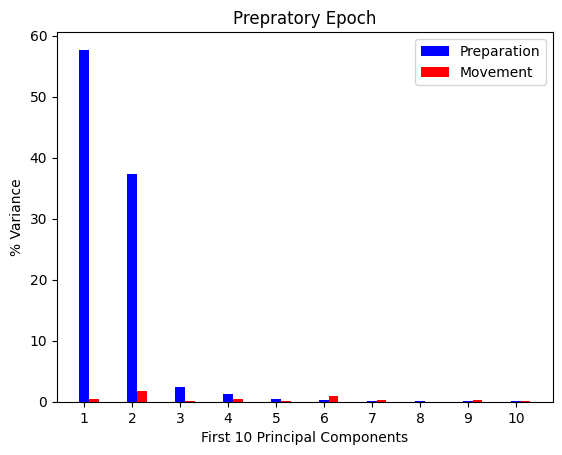

In [22]:
x_axis = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0])
width = 0.2
plt.bar(x_axis, variance_prep, width=0.2, color='b', align='center')
plt.bar(x_axis + width, proj_variance_move, width=0.2, color='r', align='center')
plt.title('Prepratory Epoch')
plt.xlabel('First 10 Principal Components')
plt.ylabel('% Variance')
plt.xticks(x_axis)
plt.legend(['Preparation', 'Movement'])
plt.show()

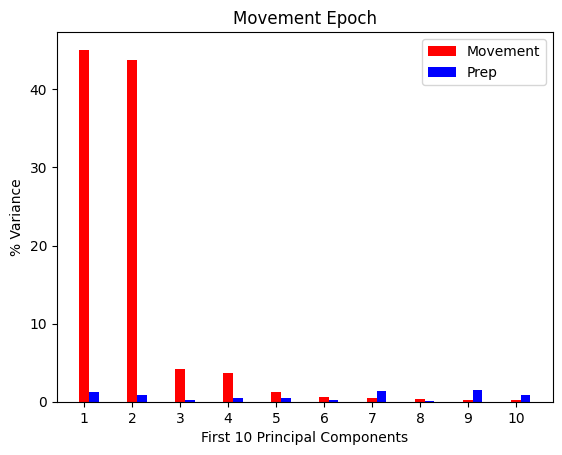

In [23]:
x_axis = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0])
width = 0.2
plt.bar(x_axis, variance_move, width=0.2, color='r', align='center')
plt.bar(x_axis + width, proj_variance_prep, width=0.2, color='b', align='center')
plt.title('Movement Epoch')
plt.xlabel('First 10 Principal Components')
plt.ylabel('% Variance')
plt.xticks(x_axis)
plt.legend(['Movement', 'Prep'])
plt.show()

3D PLOTS 

(3, 1368)


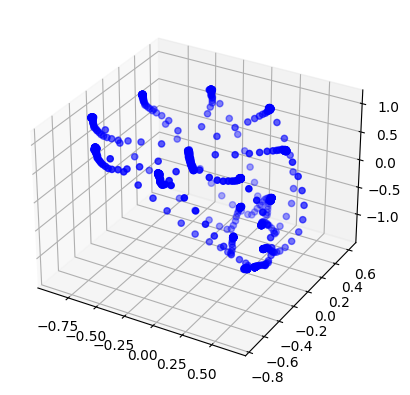

In [24]:
# Find PCA of all Rates

val_all, pc_all = eig(covarianceall)
top3_pcall = pc_prep[:,:3]
projected_all = np.matmul(np.transpose(top3_pcall), transformed_all)
print(projected_all.shape)


ax = plt.axes(projection='3d')
ax.scatter3D(projected_all[0,:], projected_all[1,:], projected_all[2,:], c='blue')

Text(0.5, 0.5, 'PC 3')

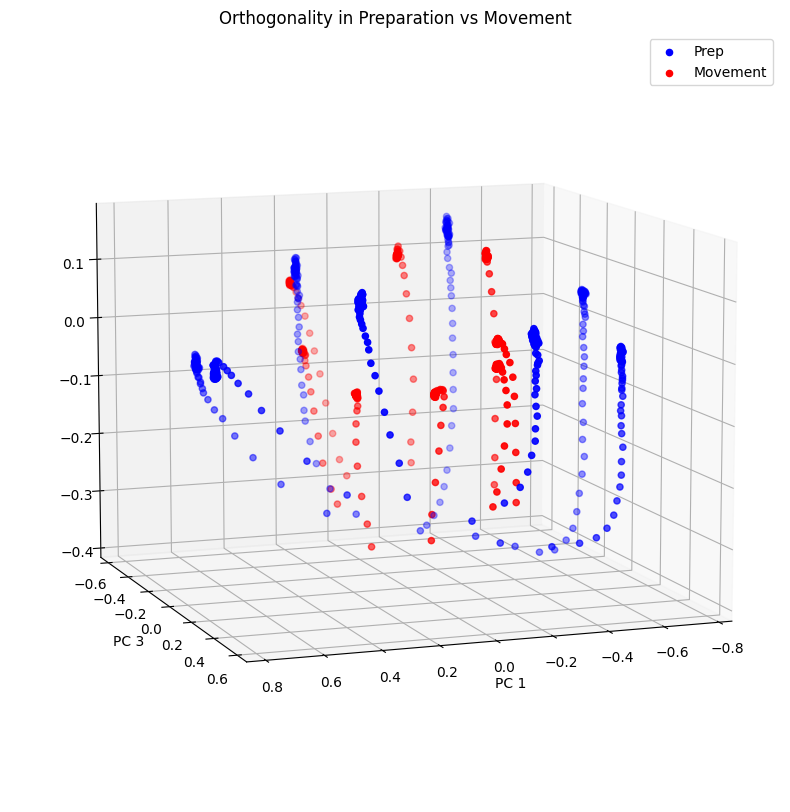

In [25]:
# Project Prep on all Rate PC

projected_prepall = np.matmul(np.transpose(top3_pcall), transformed_prep)

# Project Prep on all Rate PC
projected_moveall = np.matmul(np.transpose(top3_pcall), transformed_move)

fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

ax.scatter3D(projected_prepall[0,:], projected_prepall[1,:], projected_prepall[2,:], c='blue')
ax.scatter3D(projected_moveall[0,:], projected_moveall[1,:], projected_moveall[2,:], c='red')
ax.view_init(10, 70)
plt.legend(['Prep', 'Movement'])
plt.title('Orthogonality in Preparation vs Movement')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.ylabel('PC 3')

3 Trajectories from each direction

(400, 513, 8)
(3, 513)
here
(3, 513)
here
(3, 513)
here
(3, 513)
here
(3, 513)
here
(3, 513)
here
(3, 513)
here
(3, 513)
here


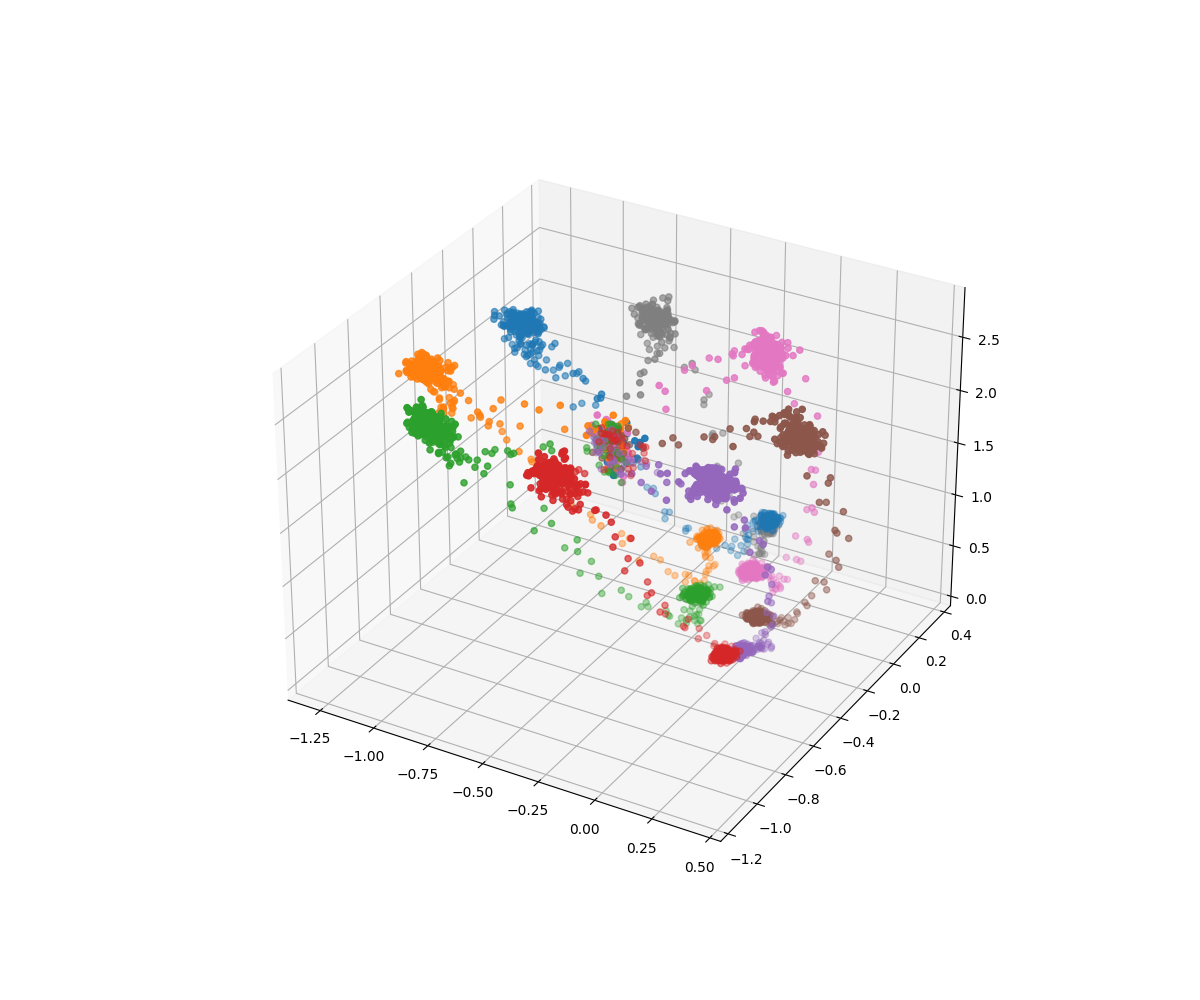

In [26]:
%matplotlib widget
print(rates3.shape)
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')


for i in range(8):

    # mean_traj = np.mean(rates3[:,:,i], axis = 1)
    # mean_traj = np.transpose(np.matlib.repmat(mean_traj,rates3[:,:,i].shape[1],1))
    # transformed_traj = rates3[:,:,i]-mean_traj

    projected_traj = np.matmul(np.transpose(top3_pcall), rates3[:,:,i])
    print(projected_traj.shape)
    ax.scatter3D(projected_traj[0,:], projected_traj[1,:], projected_traj[2,:])

    print('here')

    